# HMM 
##### Sean Wade

In [47]:
from __future__ import division, print_function
from scipy.stats import multivariate_normal as MV
import numpy as np
import itertools
import string
import codecs

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter_2.css').read())

## Homework 1

In [32]:
def calc_prob(A, B, pi):
    '''
    Calculates the probability for every pair of possible combinations of the observations.
    
    Params:
        A - Array of Transitions from j to i 
        B - Array of Transitions from i to j
        pi - Probability of i at t=0
        
        
    Returns:
        probs - A list of probabilities at each step.
        
    '''
    probs = []
    # Grab each possibile combination, of the observations.
    for O0, O1, O2, O3 in itertools.product(np.arange(3), np.arange(3),np.arange(3),np.arange(3)):
        Os = O0, O1, O2, O3
        N,M = np.shape(B)
        prob = 0
        state_sequences = list(itertools.product(np.arange(2), np.arange(2), np.arange(2), np.arange(2)))
        # For each state, calculate out the transition probabilities, by taking each stage probability and multiply
        # Assumes the markov hypothesis, and adds them to the probability sequentially
        for j, state_sequence in enumerate(state_sequences):
            subprob = pi[state_sequence[0]]
            subprob *= B[state_sequence[0], Os[0]]
            for i in xrange(1,len(state_sequence)):
                subprob *= A[state_sequence[i-1], state_sequence[i]]
                subprob *= B[ state_sequence[i],Os[i]]
            prob += subprob
        probs.append(prob)
    return probs

In [33]:
A = np.array([[0.7, 0.3], [0.4, 0.6]])
B = np.array([[0.1, 0.4, 0.5], [0.7, 0.2, 0.1]])
pi = np.array([0.6, 0.4])

In [34]:
prob_1 = calc_prob(A,B,pi)
prob_1

[0.028402359999999988,
 0.018354279999999994,
 0.017447359999999995,
 0.014652399999999996,
 0.013182399999999999,
 0.013857199999999998,
 0.012606439999999998,
 0.013002919999999999,
 0.014094639999999999,
 0.014761599999999995,
 0.0099687999999999981,
 0.0096295999999999986,
 0.010249599999999999,
 0.010172799999999999,
 0.0109376,
 0.0099967999999999984,
 0.011002399999999999,
 0.012080799999999996,
 0.012749239999999997,
 0.0088005199999999992,
 0.0085662399999999975,
 0.010021999999999998,
 0.010260799999999999,
 0.011105199999999997,
 0.010163559999999999,
 0.011387079999999997,
 0.012545359999999995,
 0.019493599999999993,
 0.012672799999999998,
 0.012073599999999999,
 0.010519999999999998,
 0.0096319999999999999,
 0.010168,
 0.0092583999999999982,
 0.0096711999999999979,
 0.010510399999999996,
 0.014201599999999998,
 0.0097567999999999978,
 0.009481599999999998,
 0.010879999999999999,
 0.011072000000000002,
 0.011968000000000005,
 0.010950399999999997,
 0.012227200000000001,
 0

In [35]:
np.sum(prob_1)

0.99999999999999978

In [36]:
def alpha_pass(A, B, pi):
    """
    Forward Alpha algorithm. 
    Args:
        A : (array) Transitions from j to i 
        B : (array) Transitions from i to j
        pi : (float) Probability of i at t=0        
    """
    probs = []
    for O0, O1, O2, O3 in itertools.product(np.arange(3), np.arange(3),np.arange(3),np.arange(3)):
        Os = O0, O1, O2, O3
        T = len(Os)
        N,M = B.shape
        alpha = np.zeros((T,N))
        alpha[0] = pi * B.T[Os[0]]
        for i in xrange(1,T):
            for j in xrange(N):
                alpha[i,j] = np.sum(alpha[i-1] * A[:,j]) 
            alpha[i] *= B.T[Os[i]]
        probs.append(np.sum(alpha[-1]))
    return probs

In [37]:
prob_2 = alpha_pass(A, B, pi)
prob_2

[0.028402359999999995,
 0.018354279999999997,
 0.017447359999999995,
 0.014652399999999998,
 0.0131824,
 0.0138572,
 0.012606439999999998,
 0.013002919999999999,
 0.014094639999999999,
 0.014761599999999995,
 0.0099687999999999981,
 0.0096295999999999968,
 0.010249599999999998,
 0.010172799999999999,
 0.010937599999999999,
 0.0099967999999999967,
 0.011002399999999997,
 0.012080799999999996,
 0.012749239999999995,
 0.0088005199999999992,
 0.0085662399999999993,
 0.010021999999999998,
 0.010260799999999999,
 0.011105199999999997,
 0.010163559999999999,
 0.011387079999999997,
 0.012545359999999998,
 0.019493599999999993,
 0.012672799999999998,
 0.012073599999999997,
 0.010519999999999998,
 0.0096319999999999999,
 0.010168,
 0.0092583999999999982,
 0.0096711999999999996,
 0.0105104,
 0.0142016,
 0.0097567999999999995,
 0.0094815999999999998,
 0.010879999999999997,
 0.011072,
 0.011967999999999999,
 0.010950399999999997,
 0.012227199999999999,
 0.013462399999999996,
 0.0140728,
 0.00983440

In [38]:
np.sum(prob_2)

1.0

These two different methods produce the same result that adds up to 1.

## Homework 2

In [29]:
class HMM(object):
    """ My implementation of a hidden markov model. """
    
    def __init__(self,A,B,pi,obs):
        self.A = A
        self.B = B
        self.pi = pi
        self.obs = obs

    def _forward(self):
        """
        Alpha Pass
        Compute the scaled forward probability matrix and scaling factors.
        Parameters
        ----------
        obs : ndarray of shape (T,)
        The observation sequence
        Returns
        -------
        alpha : ndarray of shape (T,N)
        The scaled forward probability matrix
        c : ndarray of shape (T,)
        The scaling factors c = [c_1,c_2,...,c_T]
        """
        T = len(self.obs)
        N,M = self.B.shape
        
        self.c = np.zeros(T)
        self.alpha = np.zeros((T,N))
        self.alpha[0] = self.pi * self.B.T[obs[0]]
        
        self.c[0] = np.sum(self.alpha[0])
        self.c[0] = 1./self.c[0]
        self.alpha[0] *= self.c[0]

        for i in range(1,T):
            for j in range(N):
                self.alpha[i,j] = self.alpha[i,j] + np.sum(self.alpha[i-1] * self.A[:,j] * self.B.T[self.obs[i],j]) 
            
            self.c[i] = 1./np.sum(self.alpha[i])
            self.alpha[i] *= self.c[i]
            
            
    def _backward(self):
        """
        Compute the scaled backward probability matrix.
        
        Parameters
         ----------
        obs : ndarray of shape (T,)
            The observation sequence
        c : ndarray of shape (T,)
            The scaling factors from the forward pass
        Returns
        -------
        beta : ndarray of shape (T,N)
            The scaled backward probability matrix
        """

        T = len(self.obs)
        N,M = self.B.shape
        
        self.beta = np.zeros((T,N))
        self.beta[-1] = 1
        self.beta[-1] *= self.c[-1]
        
        for i in np.arange(T-1)[::-1]:
            for j in range(N):
                self.beta[i,j] = self.beta[i,j] + np.sum(self.beta[i+1] * self.A[j,:] * B[:,self.obs[i +  1]]) 
            self.beta[i] *= self.c[i]

            
    def _delta(self):
        """
        Compute the delta probabilities.
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        alpha : ndarray of shape (T,N)
            The scaled forward probability matrix from the forward pass
        beta : ndarray of shape (T,N)
            The scaled backward probability matrix from the backward pass
        Returns
        -------
        delta : ndarray of shape (T-1,N,N)
            The delta probability array
        gamma : ndarray of shape (T,N)
            The gamma probability array
        """
        T = len(obs)
        N,M = B.shape        
    
        self.delta = np.zeros((T-1,N,N))
        self.gamma = np.zeros((T,N))
        
        for t in np.arange(T-1)[::-1]:
            for i in range(N):
                for j in range(N):
                    self.delta[t,i,j] = self.alpha[t,i] * self.A[i,j] * self.B[j,obs[t+1]] * self.beta[t+1,j]
                    
        self.gamma[:-1] = np.sum(self.delta, axis = 2)
        self.gamma[-1] = self.alpha[-1] * self.beta[-1] / np.dot(self.alpha[-1],self.beta[-1])
        
        
    def _estimate(self):
        """
        Estimate better parameter values.
        Parameters
        ----------
        obs : ndarray of shape (T,)
            The observation sequence
        delta : ndarray of shape (T-1,N,N)
            The delta probability array
        gamma : ndarray of shape (T,N)
            The gamma probability array
        """
        T,N = np.shape(self.gamma)
        N,M = self.B.shape

        for i in range(N):
            for j in xrange(N):
                self.A[j,i] = np.sum(self.delta[:,j,i], axis = 0)/np.sum(self.gamma[:-1,j], axis = 0)
                
        for i in range(M):
            ind = (self.obs == i)
            for j in range(N):
                self.B[j,i] = np.sum(self.gamma[:,j] * ind, axis = 0) /np.sum(self.gamma[:,j], axis = 0)

        self.pi = self.gamma[0,:]

        
    def fit(self, max_iter=100, tol=1e-3):
        """
        Fit the model parameters to a given observation sequence.
        Parameters
        ----------
        obs : ndarray of shape (T,)
            Observation sequence on which to train the model.
        A : stochastic ndarray of shape (N,N)
            Initialization of state transition matrix
        B : stochastic ndarray of shape (M,N)
            Initialization of state observation matrix
        pi : stochastic ndarray of shape (N,)
                Initialization of initial state distribution 
        max_iter : integer
            The maximum number of iterations to take
        tol : float
            The convergence threshold for change in log-probability
        """
        self.obs = obs
        iters = 0
        distance = 100.
        self._forward()
        log_probs = [- np.sum(np.log(self.c))]
        
        while distance > tol and iters < max_iter:
            h._forward()
            h._backward()
            h._delta()
            h._estimate()
            h._forward()
            log_probs.append( - np.sum(np.log(self.c)))
            distance = np.abs(log_probs[-2] - log_probs[-1])
            iters += 1
        self.log_probs = log_probs
        self.plot()

        
    def plot(self):
        plt.plot(np.arange(len(self.log_probs)),self.log_probs)
        plt.show()

### Problem 2

In [33]:
A = np.array([[.7, .4],[.3, .6]]).T
B = np.array([[.1,.7],[.4, .2],[.5, .1]]).T
pi = np.array([.6, .4])
obs = np.array([0, 1, 0, 2])

In [34]:
h = HMM(A,B,pi,obs)
h._forward()
print(-np.log(h.c).sum())

-4.6429135909


### Problem 3

In [35]:
h._backward()
print(h.beta)

[[ 3.1361635   2.89939354]
 [ 2.86699344  4.39229044]
 [ 3.898812    2.66760821]
 [ 3.56816483  3.56816483]]


### Problem 4 

In [39]:
h._delta()
print("delta: \n", h.delta)
print("gamma: \n", h.gamma)

delta: 
 [[[ 0.08426752  0.07285207]
  [ 0.35160496  0.38544175]]

 [[ 0.325068    0.51491691]
  [ 0.17551912  0.35254086]]

 [[ 0.15527351  0.02309112]
  [ 0.68362126  0.12890958]]]
gamma: 
 [[ 0.15711959  0.73704671]
 [ 0.8399849   0.52805998]
 [ 0.17836462  0.81253084]
 [ 0.8039794   0.1960206 ]]


### Problem 5

In [40]:
h._estimate()
print("A: \n", h.A)
print("B: \n", h.B)
print("h: \n", h.pi)

A: 
 [[ 0.48032655  0.51967345]
 [ 0.58275099  0.41724901]]
B: 
 [[ 0.16948368  0.42435299  0.40616333]
 [ 0.68153498  0.23225127  0.08621375]]
h: 
 [ 0.15711959  0.73704671]


### Problem 6

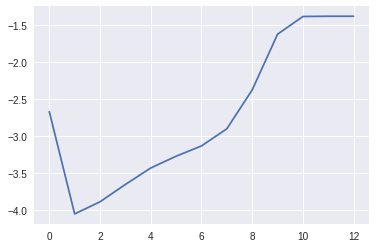

In [42]:
obs = np.array([0,1, 0, 2])
M = len(set(obs))
N = 2
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(N), size=M).T
pi = np.random.dirichlet(np.ones(N))

h = HMM(A, B, pi,obs)
h.fit()

### Problem 7

In [43]:
def vec_translate(a, my_dict):
    # translate numpy array from symbols to state numbers or vice versa
    return np.vectorize(my_dict.__getitem__)(a)

def prep_data(filename):
    # Get the data as a single string
    with codecs.open(filename, encoding='utf-8') as f:
        data=f.read().lower() #and convert to all lower case
    
    # remove punctuation and newlines
    remove_punct_map = {ord(char): \
                        None for char in string.punctuation+"\n\r"}
    data = data.translate(remove_punct_map)
   
    # make a list of the symbols in the data
    symbols = sorted(list(set(data)))
    
    # convert the data to a NumPy array of symbols
    a = np.array(list(data))
    
    #make a conversion dictionary from symbols to state numbers
    symbols_to_obsstates = {x:i for i,x in enumerate(symbols)}
    
    #convert the symbols in a to state numbers
    obs_sequence = vec_translate(a,symbols_to_obsstates)
    return symbols, obs_sequence

In [44]:
symbols, obs = prep_data('declaration.txt')

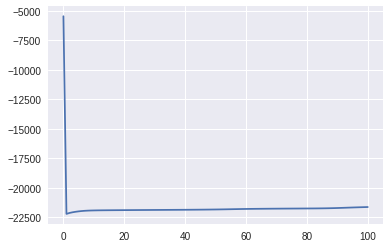

Final likelihood: -21615.1596725


In [46]:
M = len(symbols)
N = 2
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(N), size=M).T
pi = np.random.dirichlet(np.ones(N))

h = HMM(A, B, pi, obs)
h.fit()

print('Likelihood: {}'.format(-np.sum(np.log(h.c))))

In [47]:
for i in range(len(h.B)):
    print("{}, {}, {}".format(symbols[i], h.B[i,0], h.B[ -i,1]))

 , 0.299404524502, 0.0960657545768
a, 9.29920648517e-05, 0.0178135756281


In [49]:
for i in range(len(h.B.T)):
    print("{}, {}, {}".format(symbols[i], h.B.T[i,0], h.B.T[-i,1]))
    
print('Likelihood: {}'.format(-np.sum(np.log(h.c))))

 , 0.299404524502, 9.29920648517e-05
a, 0.0960657545768, 0.00113899799035
b, 0.00589793057036, 0.0166057543343
c, 2.20519860223e-05, 0.00256274547829
d, 8.05835983226e-10, 0.0265078234665
e, 0.199112625194, 0.0210714628215
f, 2.91614083342e-06, 4.7076702775e-16
g, 0.000955715513552, 0.103844368615
h, 2.27310325089e-05, 0.135278847526
i, 0.103497818108, 0.120996694741
j, 5.48800726e-47, 0.00170849698553
k, 0.000686261370157, 0.0322502167905
l, 0.0102133300592, 0.0128455927855
m, 0.000871128589215, 0.0761882476485
n, 0.049937548336, 0.0399337901135
o, 0.108454512854, 0.0523763245497
p, 0.00573504526312, 0.00314345548244
q, 1.33195182416e-42, 0.00455599196141
r, 1.77799191004e-05, 0.000710674460808
s, 0.000676798089998, 0.0993496507312
t, 0.0638164657918, 0.0358433863766
u, 0.0484453302277, 0.0512513272339
v, 1.26197295397e-23, 6.6379969135e-24
w, 0.000905920624161, 0.0717568724023
x, 6.85669481426e-23, 0.0523668178035
y, 0.0052578104449, 0.0198058920089
z, 1.33941988171e-26, 0.0178135756

### Problem 8

In [60]:
symbols, obs = prep_data('declaration.txt')
M = len(symbols)
N = 3
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(N), size=M).T
pi = np.random.dirichlet(np.ones(N))

h = HMM(A, B, pi, obs)

for i in range(len(hmm.B)):
    print("{}, {}, {}, {}".format(symbols[i], h.B.T[i,0], h.B.T[ i,1], h.B.T[i,2]))
    
for i in range(len(hmm.B.T)):
    print("{}, {}, {}, {}".format(symbols[i], h.B.T[i,0], h.B.T[ i,1], h.B.T[i,2]))

 , 0.3667663066, 0.127300940838, 0.505932752562
a, 0.179856033697, 0.0800741782265, 0.740069788076
b, 0.0484678751235, 0.506759891553, 0.444772233323
c, 0.214919980326, 0.22156771064, 0.563512309034
 , 0.3667663066, 0.127300940838, 0.505932752562
a, 0.179856033697, 0.0800741782265, 0.740069788076
b, 0.0484678751235, 0.506759891553, 0.444772233323
c, 0.214919980326, 0.22156771064, 0.563512309034
d, 0.474301667022, 0.473685044404, 0.0520132885737
e, 0.165243869292, 0.350887251436, 0.483868879272
f, 0.371595207655, 0.117763479811, 0.510641312534
g, 0.282365498998, 0.00253201410803, 0.715102486894
h, 0.182161324676, 0.696608590371, 0.121230084954
i, 0.696228577979, 0.150273836277, 0.153497585743
j, 0.461839685346, 0.115159135222, 0.423001179432
k, 0.460981026979, 0.251102460706, 0.287916512315
l, 0.168085522131, 0.0957951463197, 0.736119331549
m, 0.322573551459, 0.0618863220205, 0.61554012652
n, 0.73035506192, 0.225666932261, 0.0439780058194
o, 0.58082212873, 0.297051717284, 0.122126153986

In [53]:
symbols, obs = prep_data('declaration.txt')
M = len(symbols)
N = 4
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(N), size=M).T
pi = np.random.dirichlet(np.ones(N))

h = HMM(A, B, pi, obs)
h.fit()


for i in range(len(h.B)):
    print("{}, {}, {}, {}, {}".format(symbols[i], h.B.T[i,0], h.B.T[ i,1], h.B.T[i,2], h.B.T[i,3]))

print("Likelihood: {}".format(-np.sum(np.log(h.c))))

 , 5.51149096849e-05, 2.26591144156e-15, 0.739114900076, 6.92239389283e-05
a, 0.00145140493905, 0.192795011607, 0.00291466038842, 0.00567772354397
b, 0.0270662577004, 0.0122410193562, 1.99945052263e-19, 4.90658914711e-05
c, 0.0197925871167, 0.0378323894541, 0.0152191601415, 0.0149834119193
Final likelihood: -20438.9514685


### Problem 9 

In [56]:
symbols, obs = prep_data('WarAndPeace.txt')
M = len(symbols)
N = 2
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(N), size=M).T
pi = np.random.dirichlet(np.ones(N))

h = HMM(A, B, pi, obs)
h.fit()

for i in range(len(h.B)):
    print (u"{}, {}, {}".format(symbols[i], h.B.T[i,0], h.B.T[ i,1]))

for i in range(len(h.B.T)):
    print(u"{}, {}, {}".format(symbols[i], h.B.T[i,0], h.B.T[ i,1]))
    
print(u'Likelihood: {}'.format(-np.sum(np.log(h.c))))

Likelihood: -166694.830624
 , 0.152345751545, 0.175523417919
́, 3.27526090726e-17, 0.000144507021602
 , 0.152345751545, 0.175523417919
́, 3.27526090726e-17, 0.000144507021602
а, 0.135398576124, 0.00535994863968
б, 0.0218296729609, 0.00825130659658
в, 0.031278985975, 0.0473821714605
г, 0.00448371455141, 0.0310050102294
д, 0.0292706774015, 0.0170515465933
е, 0.0654676861383, 0.070114272274
ж, 0.0168087413704, 1.24707820633e-10
з, 0.0303571667526, 1.25338729885e-14
и, 0.0745067191924, 0.0325598000536
й, 0.000614138986068, 0.0173064097216
к, 0.0462778676472, 0.014324767192
л, 0.0616253166479, 0.0247776290517
м, 0.0300449947898, 0.0157735703182
н, 0.100210116639, 0.0167892369355
о, 0.0122309138352, 0.179852336739
п, 8.58223634966e-05, 0.0464095463319
р, 0.0254241562583, 0.0462485400715
с, 0.0167715018054, 0.0671606494734
т, 0.000336507331986, 0.0931604550931
у, 0.0368828305147, 0.0103272345063
ф, 0.00242712431026, 5.0623919155e-13
х, 0.0021777906042, 0.0110866790654
ц, 0.00593848247119, 2.5

In [57]:
symbols, obs = prep_data('WarAndPeace.txt')
M = len(symbols)
N = 3
A = np.random.dirichlet(np.ones(N), size=N).T
B = np.random.dirichlet(np.ones(N), size=M).T
pi = np.random.dirichlet(np.ones(N))

h = HMM(A, B, pi, obs)
h.fit()

for i in xrange(len(h.B)):
    print(u"{0}, {1:0.4f}, {2:0.4f}, {3:0.4f}".format(symbols[i], h.B.T[i,0], h.B.T[ i,1], h.B.T[i,2]))

for i in xrange(len(h.B.T)):
    print(u"{0}, {1:0.4f}, {2:0.4f}, {3:0.4f}".format(symbols[i], h.B.T[i,0], h.B.T[ i,1], h.B.T[i,2]))
print(u'Likelihood: {}'.format(-np.sum(np.log(h.c))))

Likelihood: -153625.465448
 , 0.4142, 0.0389, 0.0915
́, 0.0003, 0.0000, 0.0000
а, 0.0000, 0.1963, 0.0000
 , 0.4142, 0.0389, 0.0915
́, 0.0003, 0.0000, 0.0000
а, 0.0000, 0.1963, 0.0000
б, 0.0113, 0.0000, 0.0330
в, 0.0479, 0.0000, 0.0718
г, 0.0156, 0.0000, 0.0372
д, 0.0242, 0.0000, 0.0454
е, 0.0441, 0.1545, 0.0000
ж, 0.0055, 0.0000, 0.0190
з, 0.0193, 0.0000, 0.0270
и, 0.0052, 0.1453, 0.0000
й, 0.0317, 0.0000, 0.0000
к, 0.0332, 0.0000, 0.0582
л, 0.0340, 0.0000, 0.0935
м, 0.0256, 0.0000, 0.0436
н, 0.0384, 0.0000, 0.1325
о, 0.0000, 0.2685, 0.0000
п, 0.0235, 0.0000, 0.0463
р, 0.0147, 0.0000, 0.0883
с, 0.0947, 0.0000, 0.0423
т, 0.0321, 0.0000, 0.1051
у, 0.0010, 0.0650, 0.0000
ф, 0.0016, 0.0000, 0.0021
х, 0.0080, 0.0000, 0.0122
ц, 0.0007, 0.0000, 0.0077
ч, 0.0155, 0.0000, 0.0200
ш, 0.0042, 0.0000, 0.0149
щ, 0.0000, 0.0000, 0.0079
ъ, 0.0000, 0.0005, 0.0003
ы, 0.0000, 0.0419, 0.0000
ь, 0.0000, 0.0499, 0.0000
э, 0.0093, 0.0000, 0.0000
ю, 0.0165, 0.0029, 0.0000
я, 0.0276, 0.0363, 0.0000
ё, 0.0000, 

## Homework 3

In [41]:
def create_data(T, A, pi, sigma):
    N = len(A)
    states = [np.argmax(np.random.multinomial(1, pi))]
    obs = [np.random.multivariate_normal(mu[states[0]], sigma[states[0]])]
    for t in range(1,T):
        states.append(np.argmax(np.random.multinomial(1,pi)))
        obs.append(np.random.multivariate_normal(mu[states[t]], sigma[states[t]]))
    return np.array(obs)

In [42]:
pi = np.array([.3,.7])
A = np.array([[.4,.6],[.9,.1]])
mu = np.array([[2,0], [0,2]])
sigma = np.array([[[1,0],[0,1]], [[.5,0],[0,1]]])
T = 5000

data = create_data(T, A, pi, sigma)

In [48]:
class GHMM:
    """
    My implementation of a Gaussian Hidden Markov Model.
    """
    
    def __init__(self, A, pi, mu, sigma, observations, maxIters=10, iters=0, tol=1e-3):
        self.A = A
        self.pi = pi
        self.mu = mu
        self.sigma = sigma
        self.N = A.shape[0]
        self.obs = observations
        self.T = len(observations)
        self.alphas = np.zeros((self.T,self.N))
        self.deltas = np.zeros((self.T,self.N))
        self.betas = np.zeros((self.T,self.N))
        self.di_gamma = np.zeros((self.T-1,self.N, self.N))
        self.gamma = np.zeros((self.T, self.N))
        self.viterbi_best = None
        self.c = np.zeros(self.T)
        self.iters = iters
        self.maxIters = maxIters
        self.tol = tol

    def alpha_pass(self):
        """
        Alpha pass.
        Args:
          obs : The observations.
       
        Returns:
          alpha : (array) The scaled forward probability matrix
          c : (array) The scaling factor
        """
        mu = self.mu
        sigma = self.sigma
        obser=self.obs

        self.alphas[0] = self.pi*np.array([MV.pdf(obser[0], mu[i], sigma[i]) for i in range(self.N)])#self.b(obser[0])
        self.c[0] = 1/np.sum(self.alphas[0])
        self.alphas[0] *= self.c[0]

        for t in xrange(1,self.T):
            self.alphas[t] = self.alphas[t-1].dot(self.A)*np.array([MV.pdf(obser[t], mu[i], sigma[i]) for i in range(self.N)])
            self.c[t] = 1/np.sum(self.alphas[t])
            self.alphas[t] *= self.c[t]
        return self.alphas, self.c

    def beta_pass(self):
        """
        Compute the scaled backward probability matrix.
        Args:
          obs : (array) The observation sequence

        Returns:
          beta : (array) The scaled backward probability matrix
        """
        mu = self.mu
        sigma = self.sigma
        obser = self.obs
        self.betas[-1] = self.c[-1]
        for t in range(0,self.T-1)[::-1]:
            self.betas[t] = np.sum(self.A*np.array([MV.pdf(obser[t+1], mu[i], sigma[i]) for i in range(self.N)])*self.betas[t+1] , axis = 1)
            self.betas[t] *= self.c[t]
        return self.betas
    
    def find_gamma(self):
        """
        Compute the delta probabilities.
        Args:
          obs : (array) The observation sequence

        Returns:
          di-gamma : (array) The di-gamma probability array
          gamma : (array) The gamma probability array
        """
        mu = self.mu
        sigma = self.sigma
        obser = self.obs

        for t in range(self.T-1):
            for i in range(self.N):
                for j in range(self.N):
                    self.di_gamma[t][i,j] = self.alphas[t][i]*self.A[i][j]*MV.pdf(obser[t+1], mu[j], sigma[j])*self.betas[t+1][j]
        
        self.gamma[:-1] = np.sum(self.di_gamma, axis=2)
        self.gamma[self.T-1] = self.alphas[self.T-1]
        return self.di_gamma, self.gamma
    
    def estimate_lambda(self):
        obs=self.obs
        self.pi = self.gamma[0]
        
        for i in range(self.N):
            for j in range(self.N):
                numer = 0
                denom = 0
                for t in range(self.T-1):
                    numer += self.di_gamma[t][i,j]
                    denom += self.gamma[t][i]
                self.A[i][j] = numer/denom
        
        for i in range(self.N):
            self.mu[i] = np.sum([self.gamma[t,i]*obs[t] for t in range(self.T)], axis =0)/np.sum([self.gamma[t,i] for t in range(self.T)])
            self.sigma[i] = np.diag(np.sum([self.gamma[t,i]*(obs[t]-self.mu[i])**2 for t in range(self.T)], axis =0)/np.sum([self.gamma[t,i] for t in range(self.T)]))

    def fit(self):
        """
        Fit the model parameters to a given observation sequence.
        Args:
          obs : (array) Observation sequence on which to train the model.
          A : (array) Initialization of state transition matrix
          B : (array) Initialization of state observation matrix
          pi : (array) Initialization of initial state distribution
          max_iter:  (array) The maximum number of iterations to take
          tol : float
        """
        self.alpha_pass()
        
        self.oldlogProb = -np.sum(np.log(self.c))
        epsilon = self.tol+1
        
        self.iters +=1
        while (self.iters < self.maxIters and epsilon > self.tol):
            self.alpha_pass()
            self.beta_pass()
            self.find_gamma()
            
            self.estimate_lambda()
            
            self.alpha_pass()
            self.logprob = -np.sum(np.log(self.c))
            
            epsilon = np.abs(self.oldlogProb - self.logprob)
            self.oldlogProb = self.logprob
            self.iters +=1
        return self.pi, self.A, self.mu, self.sigma

In [49]:
pi = np.array([.3,.7])
A = np.array([[.4,.6],[.9,.1]])
mu = np.array([[2,0], [0,2]])
Sigma = np.array([[[1,0],[0,1]], [[.5,0],[0,1]]])
T = 5000


h = GHMM(A,pi, mu, Sigma, data)
h.fit()


(array([  2.14879561e-16,   1.00000000e+00]),
 array([[ 0.33801595,  0.66198405],
        [ 0.34826067,  0.65173933]]),
 array([[1, 0],
        [0, 2]]),
 array([[[ 2.03861187,  0.        ],
         [ 0.        ,  0.99667465]],
 
        [[ 0.48103993,  0.        ],
         [ 0.        ,  0.8703089 ]]]))